## TPE Tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge

from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

import optuna

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH_H")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,30865,0,73.697464,2,24.0,0.101093,175.393565,0.500722,173.535247,36.096518,...,323.798648,0.299493,221.695882,33.818211,587.066626,2.566872,4933.163606,2.563102,1220.610295,3064.823503
1,56,1,69.739700,0,28.0,0.212798,195.048004,0.548047,213.046946,31.734453,...,195.048004,0.548047,213.046946,31.734453,657.139780,3.031522,5550.425475,3.575500,1631.500000,3787.600000
2,30954,0,80.068440,2,17.0,0.143582,170.267530,0.545575,186.379698,36.728908,...,293.749080,0.414145,236.239837,32.057643,657.793732,2.890965,2170.192290,2.327126,791.995138,1978.973986
3,30236,1,69.656400,0,29.0,0.091508,181.028196,0.513832,184.033694,36.926329,...,204.766567,0.544235,226.620772,28.370820,695.606291,2.959220,-764.206140,3.064959,1750.726546,2795.938756
4,999,0,70.939700,2,25.0,0.148471,186.692642,0.611493,238.617863,36.628890,...,243.453948,0.468833,229.417825,28.994963,674.217352,2.885460,-1323.069060,2.545500,1191.500000,2914.950000


In [3]:
# Split by subject
subjects = dataset['RID'].unique()
first_diag_per_subject = dataset.groupby('RID')['Diagnosis'].first()

train_subs, test_subs = train_test_split(
    subjects,
    test_size=0.3,
    random_state=42,
    stratify=first_diag_per_subject
)

# Assign rows
train_df = dataset[dataset['RID'].isin(train_subs)].copy()
test_df  = dataset[dataset['RID'].isin(test_subs)].copy()

# Separate X and y
y_train = train_df['Diagnosis']
y_test  = test_df['Diagnosis']
X_train = train_df.drop(columns=['Diagnosis'])
X_test  = test_df.drop(columns=['Diagnosis'])

# -----------------------------
# Check for subject-level overlap
# -----------------------------
overlap_subjects = set(train_df['RID']).intersection(set(test_df['RID']))
if len(overlap_subjects) == 0:
    print("No subjects appear in both train and test sets.")
else:
    print(f"Overlapping subjects found: {overlap_subjects}")

print(f"Number of subjects in train: {len(train_df['RID'].unique())}")
print(f"Number of subjects in test: {len(test_df['RID'].unique())}")


No subjects appear in both train and test sets.
Number of subjects in train: 778
Number of subjects in test: 334


In [4]:
imputer_knn = IterativeImputer(
    estimator=DecisionTreeRegressor(),
    random_state=42,
)

imputer_knn.fit(X_train)
X_train_knn = imputer_knn.transform(X_train)
X_test_knn = imputer_knn.transform(X_test)

In [5]:
X_train_knn_t = pd.DataFrame(
    X_train_knn, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_knn_t = pd.DataFrame(
    X_test_knn, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [6]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_knn_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [7]:
X_train_t = pipe.transform(X_train_knn_t)
X_test_t = pipe.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((778, 23), (335, 23))

In [8]:
sel = ['RID', 'Ageatscreening', 'MMSE0m', 'HipsEntropybaseline',
       'HipsClusterShadebaseline', 'ERCsContrastbaseline',
       'ERCsCorelationbaseline', 'ERCs_thicknessbaseline',
       'ERCsVolumebaseline', 'HipposcampusVolumebaseline']

In [9]:
selected_features = [col for col in sel if col in X_train_t.columns]
selected_features

['RID',
 'Ageatscreening',
 'MMSE0m',
 'HipsEntropybaseline',
 'HipsClusterShadebaseline',
 'ERCsContrastbaseline',
 'ERCsCorelationbaseline',
 'ERCs_thicknessbaseline',
 'ERCsVolumebaseline',
 'HipposcampusVolumebaseline']

In [10]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((778, 10), (335, 10))

## TPE

In [11]:
scaler = StandardScaler()
X_train_t = scaler.fit_transform(X_train_t)
X_test_t = scaler.transform(X_test_t)

In [12]:
def objective(trial):
        
    skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
    )
    
    C = trial.suggest_float('C', 1e-3, 100, log=True)
    tol = trial.suggest_float('tol', 1e-6, 1e-2, log=True)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg', 'sag', 'saga'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    
    model = LogisticRegression(C=C,
                       tol=tol,
                       class_weight="balanced",
                       solver=solver,
                       max_iter=max_iter,
                       penalty='l2',
                       random_state=42)

    score = cross_val_score(model, X_train_t, y_train, scoring="balanced_accuracy", cv=skf)
    
    accuracy = score.mean()
    
    return accuracy

In [13]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)

study.optimize(objective, n_trials=20)

[I 2025-11-13 22:00:25,607] A new study created in memory with name: no-name-76dec977-e7e5-4b6b-a438-050e3cd39186


[I 2025-11-13 22:00:25,872] Trial 0 finished with value: 0.7349591503267974 and parameters: {'C': 0.023111358264447438, 'tol': 7.4754874451429045e-06, 'solver': 'newton-cg', 'max_iter': 246}. Best is trial 0 with value: 0.7349591503267974.
[I 2025-11-13 22:00:26,005] Trial 1 finished with value: 0.724621459694989 and parameters: {'C': 0.0038768529065558526, 'tol': 1.471784762682706e-06, 'solver': 'saga', 'max_iter': 275}. Best is trial 0 with value: 0.7349591503267974.
[I 2025-11-13 22:00:26,115] Trial 2 finished with value: 0.7373992374727669 and parameters: {'C': 0.081721400903149, 'tol': 0.00044903764531740813, 'solver': 'sag', 'max_iter': 882}. Best is trial 2 with value: 0.7373992374727669.
[I 2025-11-13 22:00:26,267] Trial 3 finished with value: 0.7199591503267972 and parameters: {'C': 0.002992198666701293, 'tol': 1.9169606851982262e-05, 'solver': 'newton-cg', 'max_iter': 770}. Best is trial 2 with value: 0.7373992374727669.
[I 2025-11-13 22:00:26,385] Trial 4 finished with value

In [14]:
study.best_params

{'C': 0.06108212986652467,
 'tol': 0.0008379877606672671,
 'solver': 'sag',
 'max_iter': 476}

In [15]:
study.best_value

0.7415822440087146

In [16]:
r = study.trials_dataframe()

r.head()

,number,value,datetime_start,datetime_complete,duration,params_C,params_max_iter,params_solver,params_tol,state
0,0,0.734959,2025-11-13 22:00:25.609564,2025-11-13 22:00:25.872479,0 days 00:00:00.262915,0.023111,246,newton-cg,0.000007,COMPLETE
1,1,0.724621,2025-11-13 22:00:25.873439,2025-11-13 22:00:26.005993,0 days 00:00:00.132554,0.003877,275,saga,0.000001,COMPLETE
2,2,0.737399,2025-11-13 22:00:26.005993,2025-11-13 22:00:26.115225,0 days 00:00:00.109232,0.081721,882,sag,0.000449,COMPLETE
3,3,0.719959,2025-11-13 22:00:26.115225,2025-11-13 22:00:26.267738,0 days 00:00:00.152513,0.002992,770,newton-cg,0.000019,COMPLETE
4,4,0.702753,2025-11-13 22:00:26.269734,2025-11-13 22:00:26.385979,0 days 00:00:00.116245,0.001563,526,newton-cg,0.000254,COMPLETE


C:\Users\steve\AppData\Local\Temp\ipykernel_17312\2278197192.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


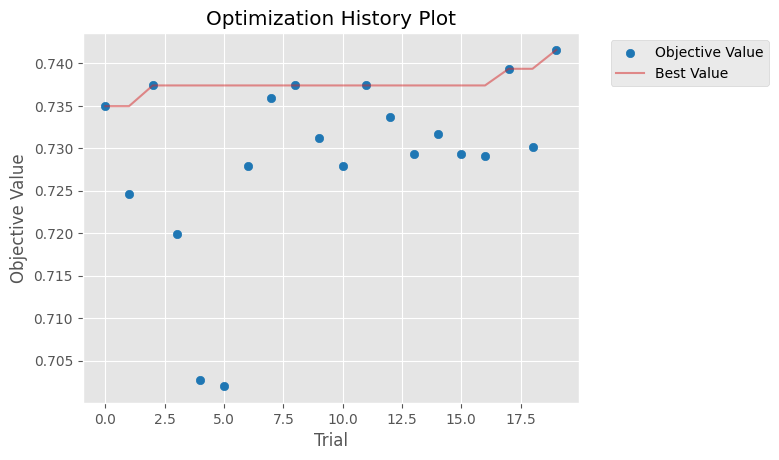

In [17]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_17312\924295173.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(


array([<Axes: xlabel='C', ylabel='Objective Value'>,
       <Axes: xlabel='max_iter'>, <Axes: xlabel='solver'>,
       <Axes: xlabel='tol'>], dtype=object)

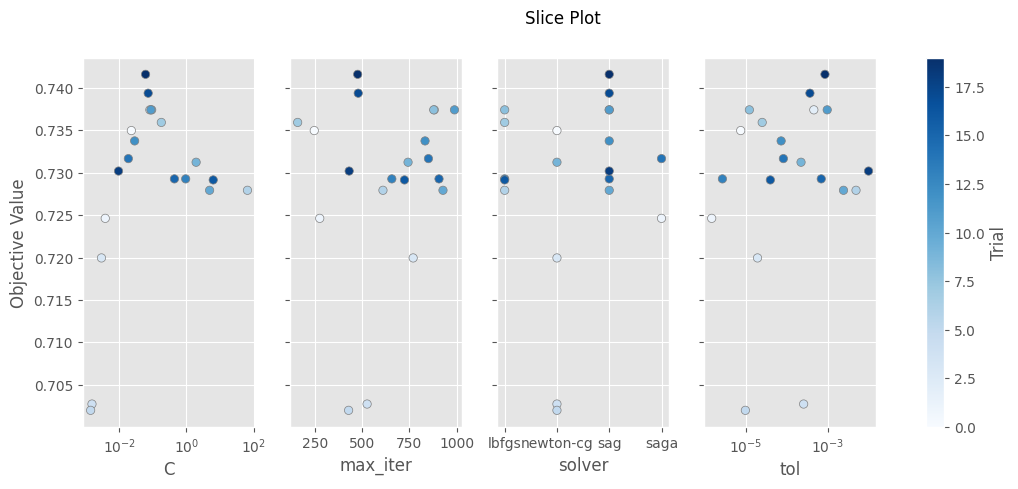

In [18]:
optuna.visualization.matplotlib.plot_slice(
    study,
    params=["C", "solver", "tol", "max_iter"],
)

C:\Users\steve\AppData\Local\Temp\ipykernel_17312\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

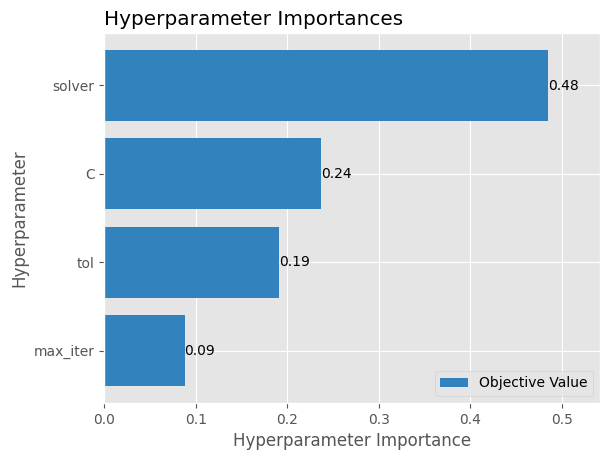

In [19]:
optuna.visualization.matplotlib.plot_param_importances(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_17312\1937692550.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf([study])


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

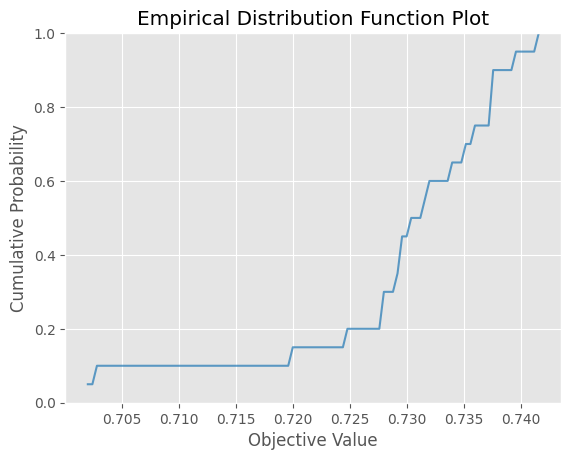

In [20]:
optuna.visualization.matplotlib.plot_edf([study])


### Classification

In [21]:
def run_model(classifier_name, sel_method, X_train, y_train):
        
        if isinstance(X_train, np.ndarray):
                columns = X_train.shape[1]
        else:
                columns = len(X_train.columns)
        
        model = LogisticRegression(C=study.best_params['C'],
                       tol=study.best_params['tol'],
                       class_weight="balanced",
                       solver=study.best_params['solver'],
                       max_iter=study.best_params['max_iter'],
                       random_state=42)

        if sel_method == "Boruta":
                sel_method = "Boruta" 
        else: 
                sel_method = "Complete"
        
        skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=skf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": sel_method,
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": columns,
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [22]:
scaler_t = StandardScaler()
X_train_missForest_t = scaler_t.fit_transform(X_train_knn_t)
X_test_missForest_t = scaler_t.transform(X_test_knn_t)

In [23]:
trained_lg_n, metrics_lg_n = run_model("Logistic Regression", "Complete", X_train_missForest_t, y_train)
trained_lg_t, metrics_lg_t = run_model("Logistic Regression", "Boruta", X_train_t, y_train)

In [24]:
validation_df = pd.concat([metrics_lg_n, metrics_lg_t])
validation_df_report = validation_df.set_index(["Classifier", "Metric", "Feature Selection", "Fit Time", "Total Features"])
validation_df_report

Mean Train  \
Classifier          Metric            Feature Selection Fit Time Total Features               
Logistic Regression balanced_accuracy Complete          0.023    23                   0.747   
                                      Boruta            0.010    10                   0.745   

                                                                                 Std Train  \
Classifier          Metric            Feature Selection Fit Time Total Features              
Logistic Regression balanced_accuracy Complete          0.023    23                   0.01   
                                      Boruta            0.010    10                   0.01   

                                                                                 Mean Test  \
Classifier          Metric            Feature Selection Fit Time Total Features              
Logistic Regression balanced_accuracy Complete          0.023    23                  0.725   
                                      Boruta            0.010    10                  0.742   

                                                                                 Std Test  
Classifier          Metric            Feature Selection Fit Time Total Features            
Logistic Regression balanced_accuracy Complete          0.023    23                 0.068  
                                      Boruta            0.010    10                 0.076

In [25]:
from sklearn.utils import resample

def bootstrap_ci(model, X, y, metric_fn, n_iterations, ci=0.95, use_proba=False):
    scores = []
    n = len(X)
    for _ in range(n_iterations):
        X_resampled, y_resampled = resample(X, y, n_samples=n, stratify=y)
        try:
            y_pred = model.predict_proba(X_resampled) if use_proba else model.predict(X_resampled)
            score = metric_fn(y_resampled, y_pred)
            if not np.isnan(score):
                scores.append(score)
        except Exception:
            # Skip this bootstrap sample if error occurs (e.g. missing class for roc_auc)
            continue
    if len(scores) == 0:
        return (np.nan, np.nan)
    lower = np.percentile(scores, (1 - ci) / 2 * 100)
    upper = np.percentile(scores, (1 + ci) / 2 * 100)
    std_dev = np.std(scores)
    return round(lower, 3), round(upper, 3), round(std_dev, 3)

In [26]:
from sklearn.metrics import confusion_matrix

def compute_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = total - (tp + fp + fn)
    specificity = tn / (tn + fp)
    return round(np.nanmean(specificity), 3)

In [27]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        if isinstance(X_train, np.ndarray):
                columns = X_train.shape[1]
        else:
                columns = len(X_train.columns)
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": accuracy_score(y_train, pred_train),
                "balanced_accuracy": balanced_accuracy_score(y_train, pred_train),
                "precision_macro": precision_score(y_train, pred_train, average="macro", zero_division=0),
                "recall_macro": recall_score(y_train, pred_train, average="macro", zero_division=0),
                "f1_macro": f1_score(y_train, pred_train, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_train, pred_train_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_train, pred_train),
        }

        metrics_test = {
                "accuracy": accuracy_score(y_test, pred_test),
                "balanced_accuracy": balanced_accuracy_score(y_test, pred_test),
                "precision_macro": precision_score(y_test, pred_test, average="macro", zero_division=0),
                "recall_macro": recall_score(y_test, pred_test, average="macro", zero_division=0),
                "f1_macro": f1_score(y_test, pred_test, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_test, pred_test_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_test, pred_test),
        }
                
        elapsed_time = time.time() - start_time
        
        # Metric functions for bootstrap CI (exclude ROC AUC here)
        metric_fns = {
                "accuracy": accuracy_score,
                "balanced_accuracy": balanced_accuracy_score,
                "precision_macro": lambda yt, yp: precision_score(yt, yp, average="macro", zero_division=0),
                "recall_macro": lambda yt, yp: recall_score(yt, yp, average="macro", zero_division=0),
                "f1_macro": lambda yt, yp: f1_score(yt, yp, average="macro", zero_division=0),
                "roc_auc_macro": lambda yt, yp: roc_auc_score(yt, yp, average="macro", multi_class="ovr"),
                "specificity_macro": lambda yt, yp: compute_specificity(yt, yp),
        }

        # Bootstrap confidence intervals
        ci_test = {
                m: bootstrap_ci(
                model, X_test, y_test, fn,
                n_iterations=1000,
                use_proba=(m == "roc_auc_macro")
                )
                for m, fn in metric_fns.items()
        }

        # Separate CI bounds and std with clear variable names
        ci_bounds = []
        std_values = []
                
        for lower, upper, std in ci_test.values():
                ci_bounds.append(f"[{round(lower, 3)}, {round(upper, 3)}]")
                std_values.append(round(std, 3)) 
                
        # Round metric values
        train_rounded = [round(score, 3) for score in metrics_train.values()]
        test_rounded = [round(score, 3) for score in metrics_test.values()] 
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Spearman",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": columns,
                "Metric": list(metrics_train.keys()),      
                "Train data": train_rounded,
                "Test data": test_rounded,
                "95% CI": ci_bounds,
                "Std Dev": std_values,
        })
        
        return pred_metrics_df

In [28]:
results = "all"
prediction_df_report = None

if results == "all":

    pred_ngb_n = eval_model("Logitic Regression", trained_lg_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_ngb_t = eval_model("Logitic Regression", trained_lg_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_ngb_n, pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":

    pred_ngb_t = eval_model("NGBoost", trained_lg_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier         Classification Time Total Features Metric                          
Spearman          Logitic Regression 0.065               23             accuracy                0.756   
                                                                        balanced_accuracy       0.744   
                                                                        precision_macro         0.719   
                                                                        recall_macro            0.744   
                                                                        f1_macro                0.725   
                                                                        roc_auc_macro           0.904   
                                                                        specificity_macro       0.876   
                                     0.040               10             accuracy                0.754   
                                                                        balanced_accuracy       0.744   
                                                                        precision_macro         0.718   
                                                                        recall_macro            0.744   
                                                                        f1_macro                0.725   
                                                                        roc_auc_macro           0.898   
                                                                        specificity_macro       0.875   

                                                                                           Test data  \
Feature Selection Classifier         Classification Time Total Features Metric                         
Spearman          Logitic Regression 0.065               23             accuracy               0.722   
                                                                        balanced_accuracy      0.709   
                                                                        precision_macro        0.668   
                                                                        recall_macro           0.709   
                                                                        f1_macro               0.678   
                                                                        roc_auc_macro          0.876   
                                                                        specificity_macro      0.863   
                                     0.040               10             accuracy               0.722   
                                                                        balanced_accuracy      0.714   
                                                                        precision_macro        0.675   
                                                                        recall_macro           0.714   
                                                                        f1_macro               0.682   
                                                                        roc_auc_macro          0.879   
                                                                        specificity_macro      0.863   

                                                                                                   95% CI  \
Feature Selection Classifier         Classification Time Total Features Metric                              
Spearman          Logitic Regression 0.065               23             accuracy           [0.675, 0.767]   
                                                                        balanced_accuracy  [0.649, 0.765]   
                                                                        precision_macro    [0.622, 0.717]   
                                                                        recall_macro       [0.649, 0.762]   
                                                                        f1_macro           

### Export model

In [29]:
trained_lg_t

LogisticRegression(C=0.06108212986652467, class_weight='balanced', max_iter=476,
                   random_state=42, solver='sag', tol=0.0008379877606672671)

In [30]:
import pickle

# Save the trained model using pickle
with open("logit_model.pkl", "wb") as file:
    pickle.dump(trained_lg_t, file)

print("Logistic model saved successfully!")

Logistic model saved successfully!


In [31]:
# Load the saved model using pickle
with open("logit_model.pkl", "rb") as file:
    loaded_model_ngb = pickle.load(file)